In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import basis, ket2dm, sigmax, sigmay, sigmaz, sigmap, sigmam, tensor, qeye, expect

In [51]:
# --- 1. AYARLAR (Fiziksel Parametreler) ---
tau = 0.1         # Sistem-Çevre Etkileşim Süresi (Dissipation strength)
theta = np.pi / 2.1  # HAFIZA GÜCÜ (Ancilla-Ancilla Etkileşim Açısı)
                   # theta = 0      -> Markovian (Hafızasız)
                   # theta = pi/2   -> Tam Swap
                   # theta = pi/4   -> Maksimum Dolanıklık (Güçlü Non-Markovian Revival)

N_steps = 2000      # Adım Sayısı (Revival görmek için biraz uzun tutalım)

In [52]:
# --- 2. OPERATÖRLERİN TANIMLANMASI (GÜNCELLENMİŞ) ---

# Tekli Operatörler
sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = sigmap()
sm = sigmam()
I2 = qeye(2)

# --- A) SİSTEM-ANCILLA ETKİLEŞİMİ ---
H_SE = tensor(sp, sm) + tensor(sm, sp)
U_SE = (-1j * H_SE * tau).expm()

# --- B) ANCILLA-ANCILLA ETKİLEŞİMİ (SWAP) ---
# SWAP Operatörü (Aynen kalıyor)
SWAP = tensor(basis(2,0)*basis(2,0).dag(), basis(2,0)*basis(2,0).dag()) + \
       tensor(basis(2,0)*basis(2,1).dag(), basis(2,1)*basis(2,0).dag()) + \
       tensor(basis(2,1)*basis(2,0).dag(), basis(2,0)*basis(2,1).dag()) + \
       tensor(basis(2,1)*basis(2,1).dag(), basis(2,1)*basis(2,1).dag())

I4 = tensor(I2, I2)

# --- KRİTİK DÜZELTME BURADA ---
# Elle sin/cos yazmak yerine Hamiltonyen mantığıyla üs alıyoruz.
# Bu işlem matrisin "Unitary" (olasılık koruyan) kalmasını garanti eder.
U_AA = (-1j * theta * SWAP).expm()

In [53]:
U_AA

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[0.07473009-0.9972038j 0.        +0.j        0.        +0.j
  0.        +0.j       ]
 [0.        +0.j        0.07473009+0.j        0.        -0.9972038j
  0.        +0.j       ]
 [0.        +0.j        0.        -0.9972038j 0.07473009+0.j
  0.        +0.j       ]
 [0.        +0.j        0.        +0.j        0.        +0.j
  0.07473009-0.9972038j]]

### STRAT-1-

In [54]:
# --- 3. BAŞLANGIÇ DURUMLARI ---

# Sistem: Süperpozisyon Durumu (|0> + |1>) / sqrt(2)
psi0_S = (basis(2, 0) + basis(2, 1)).unit()
rho_S = ket2dm(psi0_S)

# Çevre (Ancilla): Taban Durumu (|1>) -> QuTiP'te basis(2,1) genellikle "down" veya "ground" alınır.
# (Eğer basis(2,0) alırsan ve o da excited ise, sistemle enerji alışverişi olmaz)
ancilla_state = basis(2, 1) # Ground state

# İlk "Önceki Ancilla" (Hafıza taşıyıcısı boş başlar)
rho_E_prev = ket2dm(ancilla_state)
rho_current = tensor(rho_S,rho_E_prev)

In [55]:
# --- 4. SİMÜLASYON DÖNGÜSÜ ---
coherence_list = []
population_list = []
trace_list = []
environment_pop = []
environment_coh = []

for n in range(N_steps):
    
    # 1. Veri Kaydet
    coh = 2 * abs(rho_S[0, 1])
    pop = rho_S[0, 0]
    env = rho_E_prev[0, 0]
    env_coh = rho_E_prev[0,1]

    coherence_list.append(coh)
    population_list.append(pop)
    environment_pop.append(env)
    environment_coh.append(env_coh)
    
    # Trace değerini kaydet (Hata kontrolü için)
    # real değeri alıyoruz ki grafik karışmasın (complex trace 1.0+0j gibidir)
    trace_list.append(np.real(rho_S.tr())) 
    
    # --- ADIM 1: HAFIZA ETKİLEŞİMİ ---
    rho_E_curr = ket2dm(ancilla_state) # Taze ancilla
    
    # Çarpım durumunu oluştur
    rho_EE = tensor(rho_E_prev, rho_E_curr)
    
    # Hafıza operasyonu (Artık daha kararlı U_AA ile)
    rho_EE = U_AA * rho_EE * U_AA.dag()
    
    # Sisteme girecek ancillayı al ve NORMALIZE ET
    rho_E_input = rho_EE.ptrace(1)
    rho_E_input = rho_E_input.unit()  # <--- Hata temizliği 1
    
    # --- ADIM 2: SİSTEM-ÇEVRE ETKİLEŞİMİ ---
    rho_SE = tensor(rho_S, rho_E_input)
    rho_SE = U_SE * rho_SE * U_SE.dag()
    
    # --- ADIM 3: GÜNCELLEME ---
    # Sistemi al ve NORMALIZE ET
    rho_S = rho_SE.ptrace(0)
    rho_S = rho_S.unit()  # <--- Hata temizliği 2
    
    # Hafıza taşıyacak ancillayı al ve NORMALIZE ET
    rho_E_prev = rho_SE.ptrace(1)
    rho_E_prev = rho_E_prev.unit() # <--- Hata temizliği 3


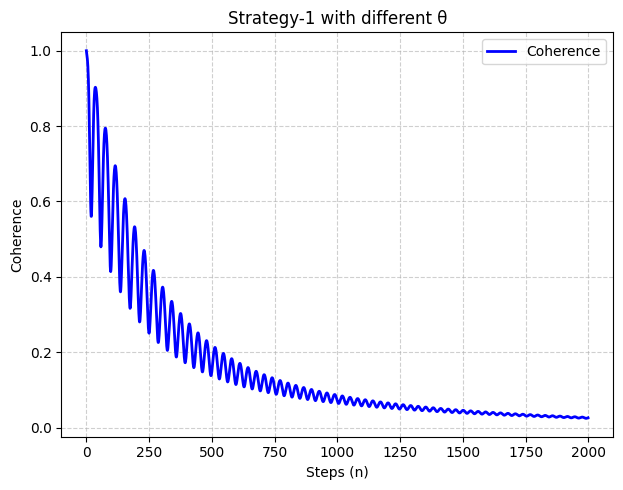

In [57]:
# --- 5. GRAFİKLEME ---
plt.figure(figsize=(12, 5))

# Grafik 1: Koherans (Revival burada görülmeli)
plt.subplot(1, 2, 1)
plt.plot(coherence_list, label='Coherence', color='b', linewidth=2)
plt.title(f"Strategy-1 with different θ")
plt.xlabel("Steps (n)")
plt.ylabel("Coherence")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# # Grafik 2: Trace Kontrolü (Düz çizgi olmalı)
# plt.subplot(1, 2, 2)
# plt.plot(trace_list, label='Trace', color='r', linestyle='--')
# plt.title("Trace (Probability) Check")
# plt.xlabel("Adım (n)")
# plt.ylabel("Tr(rho)")


plt.grid(True)

plt.tight_layout()
plt.show()

### STRAT-2-

In [58]:
# --- 3. BAŞLANGIÇ DURUMLARI ---

# Sistem: Süperpozisyon Durumu (|0> + |1>) / sqrt(2)
psi0_S = (basis(2, 0) + basis(2, 1)).unit()
rho_S = ket2dm(psi0_S)

# Çevre (Ancilla): Taban Durumu (|1>) -> QuTiP'te basis(2,1) genellikle "down" veya "ground" alınır.
# (Eğer basis(2,0) alırsan ve o da excited ise, sistemle enerji alışverişi olmaz)
ancilla_state = basis(2, 1) # Ground state

# İlk "Önceki Ancilla" (Hafıza taşıyıcısı boş başlar)
rho_E_prev = ket2dm(ancilla_state)
rho_current = tensor(rho_S,rho_E_prev)

In [59]:
coherence_list_2 = []
population_list_2 = []
trace_list_2 = []
# environment_pop_2 = []
# environment_coh_2 = []



for n in range(N_steps):
    
    
    # 1. Veri Kaydet
    rho_S=rho_current.ptrace(0)
    coh = 2 * np.abs(rho_S[0, 1])
    pop = rho_S[0, 0]
    # env = rho_E_prev[0, 0]
    # env_coh = rho_E_prev[0,1]

    coherence_list_2.append(coh)
    population_list_2.append(pop)
    trace_list_2.append(np.real(rho_S.tr()))
    # environment_pop_2.append(env)
    # environment_coh_2.append(env_coh)

    # 2. Sistem-Çevre Etkileşimi (Collision)
    # Operatör: U_SE (x) I_yok (Zaten 2 parçacık var)
    rho_current = U_SE * rho_current * U_SE.dag()
        
    # 3. Yeni Çevreyi Ekleme (Expansion)
    # Yeni yapı: S(0), En(1), En+1(2)
    rho_next_env = ket2dm(basis(2, 0)) # Yeni çevre hep |0> gelir
    rho_combined = tensor(rho_current, rho_next_env)
        
    # 4. Çevreler Arası Etkileşim (Memory Swap)
    # Etkileşim En(1) ve En+1(2) arasında. S(0) pasif (Identity).
    # Operatör yapısı: I_S (x) U_EE
    U_total_EE = tensor(I2, U_AA) 
        
    rho_combined = U_total_EE * rho_combined * U_total_EE.dag()
        
    # 5. Eski Çevreyi Atma (Partial Trace)
    # En(1)'i atıyoruz. Geriye S(0) ve En+1(2) kalıyor.
    # ptrace([0, 2]) -> 0 ve 2'yi tut demektir.
    rho_current = rho_combined.ptrace([0,2])
        
    # Döngü sonunda elimizdeki rho_current artık (S, En+1) oldu.
    # Bir sonraki adımda bu En+1, "En" rolünü üstlenecek.

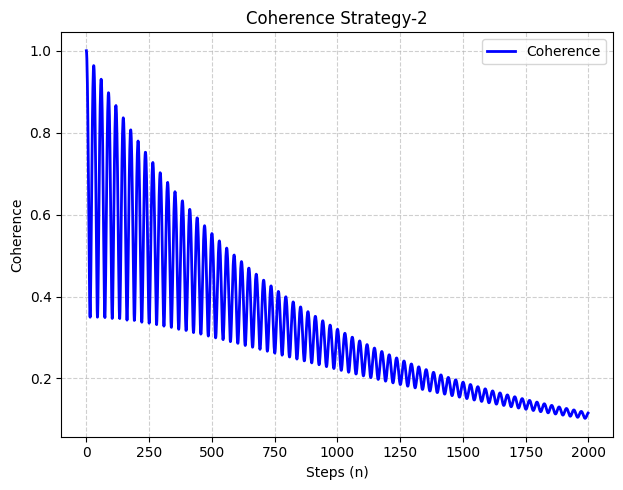

In [60]:
# --- 5. GRAFİKLEME ---
plt.figure(figsize=(12, 5))

# Grafik 1: Koherans (Revival burada görülmeli)
plt.subplot(1, 2, 1)
plt.plot(coherence_list_2, label='Coherence', color='b', linewidth=2)
plt.title(f"Coherence Strategy-2")
plt.xlabel("Steps (n)")
plt.ylabel("Coherence")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# # Grafik 2: Trace Kontrolü (Düz çizgi olmalı)
# plt.subplot(1, 2, 2)
# plt.plot(trace_list_2, label='Trace', color='r', linestyle='--')
# plt.title("Trace (Probability) Check")
# plt.xlabel("Adım (n)")
# plt.ylabel("Tr(rho)")


plt.grid(True)

plt.tight_layout()
plt.show()